In [9]:
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [10]:
from __future__ import print_function
import math
import numpy as np
import time
from sklearn import linear_model
import sys
import os
lib_path = os.path.abspath('../falconn/python_swig')
sys.path.append(lib_path)
import falconn
import readsvm 
from cdexperiments import *

In [11]:
def get_data_plot(stats):
    xvals = np.array([x1 for x1, y1 in stats])
    yvals = np.array([y1 for x1, y1 in stats])
    return (xvals,yvals)
def readfile(filename, n,d):
    y = np.zeros(n) # targets
    X = np.zeros((n,d)) # input matrix each row is a sample data point
    li = 0 
    with open(filename, "rb") as f:
        for line in f:
           if li>=n : 
             break;
           parts = line.split()
           y[li] = float(parts[0])
           for i in range(len(parts)): 
                if i >0 and parts[i] != '\n': 
                    fparts = parts[i].split(":")
                    X[li,int(fparts[0])-1] = float(fparts[1])
           li = li +1
    return (y,X)

def w_alpha(alpha,X,lambd,verbose=False): # check the equation 3 of (SDCA) paper
    n, d = X.shape
    w = np.zeros(d)
    for i in range(n): 
        w = w + alpha[i]*X[i,:]/lambd
    w = w/n
    return w


def dual_obj(alpha,y,X,lambd,verbose=False): # computes the dual function value for a given parameter alpha 
    da = 0
    n, d = X.shape
    for i in range(n): 
        if alpha[i]*y[i] <= 1 and alpha[i]*y[i] >= 0:
            da = da + alpha[i]*y[i]
        else:
            da = da + float("inf")
    da = da / n 
    da = da - 0.5*lambd*np.square(np.linalg.norm(w_alpha(alpha,X,lambd)))
    return da  

In [12]:
def meta_svm(y,A, lambd, num_effective_passes, order_generator, verbose=False):
  #each row contains a data point with dim d 
  inv_sq_row_norms = np.divide(1.0, np.square(np.linalg.norm(A, axis=1)))
  n, d = A.shape
  alpha = np.zeros(n)
  w = w_alpha(alpha,A,lambd)

  obj_value = dual_obj(alpha,y,A,lambd)
  if verbose:
    print(" Initial objective value: {}".format(obj_value))
    
  stats = [(0.0, obj_value)]
  completed_effective_passes = 0.0
  while completed_effective_passes < num_effective_passes:
    coords = order_generator( A, alpha)
    for ii in coords:
        alpha_i_old = alpha[ii]
        xi = X[ii,:]
        yi = y[ii]
        inv_sqi = inv_sq_row_norms[ii]
        # coordinate update step 
        delta_alpha_i = yi*max(0,min(1,(lambd*n*(1-yi*np.dot(xi,w))*inv_sqi)+alpha_i_old*yi)) - alpha_i_old
        # update the dual and primal paramters
        alpha[ii] = alpha[ii] + delta_alpha_i
        w = w + delta_alpha_i*xi/(lambd*n)
    completed_effective_passes += len(coords) / float(n)
    obj_value = dual_obj(alpha,y,A,lambd)
    stats.append((completed_effective_passes, obj_value))
    if verbose:
      print("  Objective value after {} effective passes: {}".format(completed_effective_passes, obj_value))
    
  return (alpha, stats,w)


In [13]:
def svm_randomiid( y,A, lambd, num_passes, verbose=False):
  n, d = A.shape
  def randiid_order_generator(*unused):
    return np.random.randint(n, size=n)
  if verbose:
    print("Random iid coordinate descent DCA solver")
  return meta_svm(y, A, lambd, num_passes, randiid_order_generator, verbose)
def svm_cyclic( y,A, lambd, num_passes, verbose=False):
  n,d = A.shape
  def cyclic_order_generator(*unused):
    return range(n)
  if verbose:
    print("Cyclic coordinate descent Lasso solver")
  return meta_svm(y, A, lambd, num_passes, cyclic_order_generator, verbose)

In [14]:
n = 10000; 
d = 24; 
import readsvm 
filename = "../datasets/ijcnn1"
y, X = readfile(filename,n,d)
A = np.zeros((n,d))
for i in range(n): 
    A[i,:] = y[i]*X[i,:]

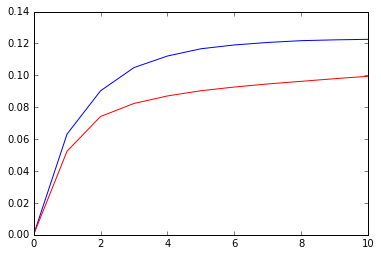

In [15]:
lambd = 1.0/n
(alpha,stats,w_r) = svm_randomiid(y,X, lambd, 10)
t, f_r = get_data_plot(stats);
(alpha_s,stats_s,w_s) = svm_cyclic(y,X,lambd,10)
t, f_s = get_data_plot(stats_s)
plot(t,f_r,color='blue')
plot(t,f_s,color='red')

In [99]:
w = w_alpha(alpha_s,A,lambd)

In [21]:
from sklearn import svm
clf = svm.LinearSVC(C = 1./(n*lambd),fit_intercept=False)
clf.fit(X, y) 
np.sqrt(np.linalg.norm(clf.coef_-w_r))

2.3280935001845298

In [18]:
np.linalg.norm(clf.coef_)

29.025278938629629